In [54]:
#coding=utf-8

#from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
import os


In [55]:
#数据预处理，data_transforms是字典
data_transforms = {
    'train': transforms.Compose([   #此函数可以包含多个数据预处理的方法
        transforms.Scale(230),    #自适应缩放到最大边长230
        transforms.CenterCrop(224),  #居中裁剪224*224
        transforms.RandomHorizontalFlip(),  #随机水平翻转，增加训练集多样性
        transforms.ToTensor(),  #转化成tensor格式
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  #均值为0.5，标准差为0.5进行归一化
    ]),
    'test': transforms.Compose([        #测试数据集
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


E:\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [56]:
data_directory = 'Tfldata'   #数据文件夹名
#设置数据路径和预处理方法
trainset = datasets.ImageFolder(os.path.join(data_directory, 'train'), data_transforms['train'])
testset = datasets.ImageFolder(os.path.join(data_directory, 'test2'), data_transforms['test'])
#加载数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,shuffle=True, num_workers=4)

[[[0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  ...
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]]

 [[0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  ...
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]]

 [[0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  [0.62352943 0.5882353  0.58431375]
  ...
  [0.41568628 0.3882353  0.43137255]
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]]

 ...

 [[0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]
  [0.52156866 0.5019608  0.27450982]
  ...
  [0.20784312 0.26666668 0.1490196 ]
  [0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]]

 [[0.5        0.5        0.5       ]
  [0.5        0.5        0.5       ]


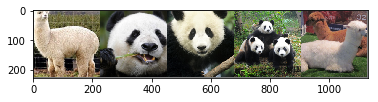

In [57]:
def imshow(inputs):
    
    inputs = inputs / 2 + 0.5
    inputs = inputs.numpy().transpose((1, 2, 0))
    print(inputs)
    plt.imshow(inputs)
    plt.show()
    
inputs,classes = next(iter(testloader))

imshow(torchvision.utils.make_grid(inputs))

In [58]:
#导入预设的alexnet模型和参数
alexnet = models.alexnet(pretrained=True) 
#遍历模型中的所有参数，requires_grad = False ，限制参数更新，保持特征提取层不变（卷积层）
for param in alexnet.parameters():
    param.requires_grad = False 
    
    
#重新定义模型的全连接层部分，改为2分类任务
alexnet.classifier=nn.Sequential(
    nn.Dropout(),
    nn.Linear(256*6*6,4096),   #9216*4096
    nn.ReLU(inplace =True),
    nn.Dropout(),
    nn.Linear(4096,4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096,2),)   #与原来的区别在于最后一层输出改为2

CUDA = torch.cuda.is_available()

if CUDA:   
    alexnet = alexnet.cuda()

In [59]:
criterion = nn.CrossEntropyLoss()   #交叉熵函数作为损失函数
optimizer = optim.SGD(alexnet.classifier.parameters(), lr=0.001, momentum=0.9)   #优化器为随机梯度下降，只传入全连接层的参数进行优化

In [60]:
#
def train(model,criterion,optimizer,epochs=1):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader,0):   #enumerate将可遍历的数据组合成一个索引序列，并列出数据和下标
            inputs,labels = data
            if CUDA:
                inputs,labels = inputs.cuda(),labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            if i%10==9:
                print('[Epoch:%d, Batch:%5d] Loss: %.3f' % (epoch+1, i+1, running_loss / 100))
                running_loss = 0.0
 
    print('Finished Training')

In [61]:
def test(testloader,model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
       # print(outputs)
        ts, predicted = torch.max(outputs.data, 1) 
        #print(ts)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy on the test set: %d %%' % (100 * correct / total))

In [62]:
def load_param(model,path):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))

def save_param(model,path):
    torch.save(model.state_dict(),path)


In [63]:
load_param(alexnet,'tl_model.pkl')

# train(alexnet,criterion,optimizer,epochs=4)

# save_param(alexnet,'tl_model.pkl')

# test(testloader,alexnet)

In [64]:
test(testloader,alexnet)

tensor([1, 1, 1, 0, 0], device='cuda:0')
Accuracy on the test set: 100 %
